# 以主題模型探討台灣近期新聞中之運動相關議題

## 1.引入套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from matplotlib import font_manager
font_set = {f.name for f in font_manager.fontManager.ttflist}
# matplotlib.rcParams['font.family'] = ['Noto Sans Mono CJK TC', 'sans-serif']
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
# plt.plot((1, 2, 3), (4, 3, -1))
# plt.title("聲量圖")

## 2. 資料前處理

資料來源: Tarflow UDN聯合新聞網爬蟲 <br>
資料蒐集期間: 2023/02/01-2023/05/02 <br>
資料筆數: 5406 <br>

In [4]:
udn = pd.read_csv("rawData/udn_news_04.csv")  # 匯資料
udn.head(3)

,system_id,artTitle,artDate,artCatagory,artSecondCatagory,artUrl,artContent,dataSource
0,1,經典賽／張育成前隊友參戰 兄弟檔守荷蘭外野,2023-02-03 11:08:00,運動,經典賽,https://udn.com/news/story/10785/6946445,美國職棒克里夫蘭守護者外野手帕拉修斯（Richie Palacios）將加入荷蘭國家隊，參加...,UDN
1,2,經典賽／中華隊前5場熱身賽不接客 球迷進場等月底,2023-02-03 12:49:00,運動,經典賽,https://udn.com/news/story/10785/6946844,中華隊備戰世界棒球經典賽，規畫8場自辦熱身賽，今天公布前5場比賽時間，皆未售票、未開放球迷進...,UDN
2,3,經典賽／日媒整理各國大咖教練 王建民與眾傳奇齊名,2023-02-03 14:40:00,運動,經典賽,https://udn.com/news/story/10785/6947136,世界棒球經典賽即將在3月8日開打，各國不只擁有眾多大咖球星，連教練團也相當豪華，日媒昨日也整...,UDN


In [5]:
# 移除網址格式
# 只留下中文字
udn["artContent"] = udn["artContent"].str.replace("(http|https)://.*", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("(http|https)://.*", "", regex=True)
udn["artContent"] = udn["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn["artTitle"] = udn["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
udn['content'] = udn['artContent']


udn = udn.loc[:,["content", "artUrl", "artCatagory", 'artDate']]  # 文章內容 文章連結
udn.head(3)

,content,artUrl,artCatagory,artDate
0,美國職棒克里夫蘭守護者外野手帕拉修斯將加入荷蘭國家隊參加月日起在台中的經典賽首輪他與台灣好手...,https://udn.com/news/story/10785/6946445,運動,2023-02-03 11:08:00
1,中華隊備戰世界棒球經典賽規畫場自辦熱身賽今天公布前場比賽時間皆未售票未開放球迷進場月底則有對...,https://udn.com/news/story/10785/6946844,運動,2023-02-03 12:49:00
2,世界棒球經典賽即將在月日開打各國不只擁有眾多大咖球星連教練團也相當豪華日媒昨日也整理本屆賽事...,https://udn.com/news/story/10785/6947136,運動,2023-02-03 14:40:00


In [6]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stopwords.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

udn["words"] = udn["content"].apply(getToken)
udn.head()

Building prefix dict from c:\Users\collin\Desktop\社群媒體\第三次讀書會\dict\dict.txt ...
2023-05-03 20:19:51,306 : DEBUG : Building prefix dict from c:\Users\collin\Desktop\社群媒體\第三次讀書會\dict\dict.txt ...
Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.ubc941d335c6b0b25ebb4bdf764a7f175.cache
2023-05-03 20:19:51,308 : DEBUG : Loading model from cache C:\Users\collin\AppData\Local\Temp\jieba.ubc941d335c6b0b25ebb4bdf764a7f175.cache
Loading model cost 0.316 seconds.
2023-05-03 20:19:51,624 : DEBUG : Loading model cost 0.316 seconds.
Prefix dict has been built successfully.
2023-05-03 20:19:51,625 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,美國職棒克里夫蘭守護者外野手帕拉修斯將加入荷蘭國家隊參加月日起在台中的經典賽首輪他與台灣好手...,https://udn.com/news/story/10785/6946445,運動,2023-02-03 11:08:00,"[美國, 職棒, 克里夫蘭, 守護, 外野手, 帕拉, 修斯將, 加入, 荷蘭, 國家隊, ..."
1,中華隊備戰世界棒球經典賽規畫場自辦熱身賽今天公布前場比賽時間皆未售票未開放球迷進場月底則有對...,https://udn.com/news/story/10785/6946844,運動,2023-02-03 12:49:00,"[中華隊, 備戰, 世界, 棒球, 經典賽, 規畫, 自辦, 熱身賽, 今天, 公布, 前場..."
2,世界棒球經典賽即將在月日開打各國不只擁有眾多大咖球星連教練團也相當豪華日媒昨日也整理本屆賽事...,https://udn.com/news/story/10785/6947136,運動,2023-02-03 14:40:00,"[世界, 棒球, 經典賽, 開打, 各國, 擁有, 眾多, 大咖, 球星, 教練團, 豪華,..."
3,世界棒球經典賽即將在月開打被視為奪冠熱門的多明尼加隊組隊卻不如預期順利先前提出的人名單中有人...,https://udn.com/news/story/10785/6947368,運動,2023-02-03 15:45:00,"[世界, 棒球, 經典賽, 開打, 視為, 奪冠, 熱門, 多明尼加隊, 組隊, 預期, 順..."
4,日職西武隊台灣投手張奕今天春訓分組從一軍調往二軍傳出右肩不適所屬經紀公司信心野球也證實有發炎...,https://udn.com/news/story/10785/6947409,運動,2023-02-03 15:49:00,"[日職, 西武隊, 台灣, 投手, 張奕, 今天, 春訓, 分組, 一軍, 調往, 二軍, ..."


## 3. Lexicon-based / 人工給定主題的主題模型

In [7]:
udn['artCatagory'].unique()

array(['運動'], dtype=object)

In [8]:
## 定義主題
sport_cnt = udn.loc[udn['artCatagory'] == '運動',:]['words'].explode().value_counts().head(100)
sport_cnt.index

Index(['今天', '經典賽', '比賽', '中華隊', '世界', '球員', '棒球', '球隊', '台灣', '表示', '投手',
       '先發', '安打', '賽事', '選手', '表現', '日本', '球迷', '今年', '聯盟', '拿下', '最後', '大聯盟',
       '賽程', '戰績', '去年', '季後賽', '主場', '高中', '預賽', '成為', '比分', '擊敗', '面對', '機會',
       '最終', '籃板', '本季', '領先', '教練', '出賽', '時間', '美國', '希望', '生涯', '紀錄', '勇士',
       '大谷翔平', '運動', '記者', '分組', '昨天', '敲出', '成績', '冠軍', '目前', '進行', '助攻',
       '張育成', '完整', '悍將', '球場', '分析', '湖人', '總教練', '新聞', '對手', '球星', '專欄',
       '即時', '狀況', '得分', '失分', '開打', '中華', '獲得', '出現', '包括', '攝影', '賽季', '熱身賽',
       '參加', '職棒', '排名', '晉級', '太陽', '球團', '取得', '打擊', '中信', '兄弟', '富邦', '幫助',
       '棒球場', '提供', '過去', '隊友', '對決', '完成', '訓練'],
      dtype='object', name='words')

分成5類

In [144]:
custom_topic_word = {
    "MLB":["大谷翔平", "經典賽", "大聯盟", "先發", "張育成"],
    "桌球":["林昀儒","莊智淵","鄭怡靜","桌球","挑戰賽"],
    "NBA":["湖人", "勇士", "太陽", "公鹿","籃網","金塊", "熱火", "尼克"],
    "PLG":["林志傑","楊敬敏","勇士","國王","夢想家","鋼鐵人"],
    "羽球":["周天成","戴資穎","王子維","王齊麟","李洋","盧敬堯","楊博涵","楊博軒","李哲輝","羽球","公開賽","奧運","亞運"],
    "T1":["海神","台啤","雲豹","太陽","台鋼"]
}

In [145]:
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [146]:
vocabularies

array(['亞運', '先發', '公開賽', '公鹿', '勇士', '台啤', '台鋼', '周天成', '國王', '夢想家',
       '大聯盟', '大谷翔平', '太陽', '奧運', '尼克', '張育成', '戴資穎', '挑戰賽', '李哲輝', '李洋',
       '林志傑', '林昀儒', '桌球', '楊博涵', '楊博軒', '楊敬敏', '海神', '湖人', '熱火', '王子維',
       '王齊麟', '盧敬堯', '籃網', '經典賽', '羽球', '莊智淵', '鄭怡靜', '金塊', '鋼鐵人', '雲豹'],
      dtype='<U4')

In [147]:
udn_corpus = udn['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
udn_matrix = vectorizer.fit_transform(udn_corpus)

udn_matrix = udn_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [148]:
udn_matrix.shape

(5406, 40)

In [149]:
df_count = pd.DataFrame({})


for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = udn_matrix[:, idx].sum(axis=1)
df_count

,topic_MLB,topic_桌球,topic_NBA,topic_PLG,topic_羽球,topic_T1
0,13,0,0,0,0,0
1,1,0,0,0,0,0
2,3,0,0,0,0,0
3,3,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
5401,2,0,0,0,0,0
5402,2,0,0,0,0,0
5403,2,0,0,0,0,0
5404,2,0,0,0,0,0


In [153]:
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.tail(200)

,topic_MLB,topic_桌球,topic_NBA,topic_PLG,topic_羽球,topic_T1
5206,1.000000,0.0,0.0,0.000000,0.0,0.0
5207,1.000000,0.0,0.0,0.000000,0.0,0.0
5208,1.000000,0.0,0.0,0.000000,0.0,0.0
5209,0.666667,0.0,0.0,0.333333,0.0,0.0
5210,0.500000,0.5,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...
5401,1.000000,0.0,0.0,0.000000,0.0,0.0
5402,1.000000,0.0,0.0,0.000000,0.0,0.0
5403,1.000000,0.0,0.0,0.000000,0.0,0.0
5404,1.000000,0.0,0.0,0.000000,0.0,0.0


## 4. LDA 主題模型
Latent Dirichlet allocation 簡稱 LDA，是一種主題模型，他可以將資料集中每篇文檔的主題按照機率分佈，他是無監督學習法，訓練時不需要手動標註，只需要給文黨集、主題數，也可以根據一些參數(alpha、Beta)來改變模型訓練的結果，以下使用 gensim 套件來示範如何訓練 LDA 模型。

**4.1 正式處理新聞**

In [18]:
docs = udn['words'].to_list()
docs[0]

['美國',
 '職棒',
 '克里夫蘭',
 '守護',
 '外野手',
 '帕拉',
 '修斯將',
 '加入',
 '荷蘭',
 '國家隊',
 '參加',
 '台中',
 '經典賽',
 '首輪',
 '台灣',
 '好手',
 '張育成',
 '短暫',
 '同隊',
 '瑞奇',
 '帕拉',
 '修斯是',
 '去年',
 '升上',
 '大聯盟',
 '菜鳥',
 '他將',
 '哥哥',
 '喬許',
 '帕拉',
 '修斯將',
 '共同',
 '效力',
 '荷蘭隊',
 '鎮守',
 '左右',
 '外野',
 '喬許',
 '兩年',
 '升上',
 '大聯盟',
 '新秀',
 '荷蘭',
 '台灣',
 '同組',
 '預計',
 '洲際',
 '球場',
 '交手',
 '曾經',
 '同隊',
 '瑞奇',
 '帕拉',
 '修斯',
 '張育成',
 '可望',
 '球場',
 '對陣',
 '帕拉',
 '修斯',
 '球隊',
 '體系',
 '張育成',
 '後輩',
 '加入',
 '守護',
 '時稱',
 '印地安人',
 '聯盟',
 '新人',
 '聯盟',
 '出發',
 '當年',
 '張育成',
 '聯盟',
 '高層級',
 '隔年',
 '升上',
 '大聯盟',
 '帕拉',
 '修斯向',
 '爬升',
 '過程',
 '聯盟',
 '大聯盟',
 '下放',
 '張育成',
 '短暫',
 '同隊',
 '張育成',
 '去年',
 '守護',
 '指定',
 '讓渡',
 '球隊',
 '聯盟',
 '拉上',
 '多名',
 '新秀',
 '帕拉',
 '修斯',
 '帕拉',
 '修斯是',
 '去年',
 '守護',
 '隊名',
 '大聯盟',
 '初登板',
 '新秀',
 '出賽',
 '打擊率',
 '成支',
 '二壘打',
 '打點',
 '荷蘭隊',
 '陣中',
 '擁有',
 '多名',
 '大聯盟',
 '球員',
 '經驗',
 '較少',
 '帕拉',
 '修斯',
 '兄弟',
 '經驗',
 '豐富',
 '明星',
 '游擊手',
 '波賈茲',
 '工具人',
 '普羅',
 '明星',
 '投手',
 '簡森',
 '好手']

In [19]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 99% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2023-05-03 20:20:59,506 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-05-03 20:21:00,270 : INFO : built Dictionary<58127 unique tokens: ['下放', '二壘打', '交手', '他將', '修斯']...> from 5406 documents (total 1173320 corpus positions)
2023-05-03 20:21:00,271 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<58127 unique tokens: ['下放', '二壘打', '交手', '他將', '修斯']...> from 5406 documents (total 1173320 corpus positions)", 'datetime': '2023-05-03T20:21:00.271189', 'gensim': '4.3.1', 'python': '3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'created'}
2023-05-03 20:21:00,311 : INFO : discarding 43290 tokens: [('修斯向', 1), ('修斯將', 1), ('修斯是', 1), ('喬許', 1), ('成支', 3), ('時稱', 2), ('普羅', 2), ('瑞奇', 2), ('五台', 3), ('一代名', 1)]...
2023-05-03 20:21:00,312 : INFO : keeping 14837 tokens which were in no less than 5 and no more than 5351 (=99.0%) documents
2023-05-03 20:21:00,334 : INFO : resulting dictionar

Dictionary<14837 unique tokens: ['下放', '二壘打', '交手', '他將', '修斯']...>


In [20]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

下放: 0
二壘打: 1
交手: 2
他將: 3
修斯: 4
兄弟: 5
克里夫蘭: 6
兩年: 7
共同: 8
出發: 9
出賽: 10
初登板: 11


In [21]:
pprint(" ".join(udn['words'].iloc[600]))

('具有 意義 登板 佐佐木 朗希投 失分 飆出 三振 球速 來到 公里 球數 限制 日本隊 領先 捷克隊 退場 休息 將好 表現 獻給 天上 父親 祖父母 '
 '日本隊 早早 宣布 佐佐木 朗希 扛起 世界 棒球 經典賽 三戰 先發 以球 投完 繳出 敲出 安打 有次 三振 失分 非責 失分 成績 佐佐木 朗希 '
 '直接 投出 公里 引起 現場 驚呼 飛球 出局 三振 迅速 抓到 出局 敲出 二壘 安打 成功 對手 敲出 滾地 游擊手 中野 拓夢 失誤 反讓 捷克 '
 '得分 佐佐木 朗希 第局 最快 球速 飆到 公里 先掉 分數 第局 繼續 狂飆 速球 連續 兩人 揮棒 落空 三振 一棒 投出 四壞 保送 再用 滾地 '
 '出局 拿下 出局數 第局 佐佐木 朗希 再次 三振 開局 敲出 安打 投出 四壞 再次 捷克隊 攻上 得點 三振 中外野 飛球 連抓個 出局數 安全 '
 '下庄局 佐佐木 朗希 續投 三振 投出 觸身球 但用 三振 凍結 壘包 因用 球數 達到 超過 經典賽 單場 球數 限制 退場 休息 交接 宇田 川優 '
 '三振 結束 半局 日本隊 掉分 局下 日本隊 著近 藤健介 二壘打 村上 宗隆 保送 出局 取得 攻勢 吉田 正尚 二壘打 山田 哲人 安打 一口氣 '
 '取得 分將 比數 超前 佐佐木 朗希來 特別 日子 日本 地震 佐佐木 朗希 失去 父親 祖父母 之後 媽媽 搬到 岩手縣 大船 渡市 居住 過去 '
 '佐佐木 朗希以 頂級 投手 之姿 國際賽場 活躍 登板 先發 受訪 表示 時間 流逝 漸漸 忘記 棒球 輸掉 比賽 那種 遺憾 心情 漸漸 忘記 重要 '
 '看待 經典賽 即時 新聞 比分 完整 賽程 預賽 分組 戰績 經典賽 專欄 分析 經典賽 風雲 退路 一戰 中華隊 贏得 強勢 張育成 滿貫砲 一棒 '
 '帶動 氣勢 第到 攻勢 一波接 一波 終場 賞給 荷蘭隊 本屆 賽會 中華隊 能不能 前進 東京 命運 交到 左投 陳仕朋 手中 明天 面對 紅色 閃電 '
 '古巴隊 先發 對手 古巴 則是 推出 樂天 桃猿隊 洋投 雷法 中華隊 今天 擊敗 荷蘭隊 敗部復活 進入 中華隊 的吳 哲源 成為 英雄 總教練 '
 '林岳平 稱隊 哲源 福氣 中華隊 經典賽 首戰 滑鐵盧 步步 走回 正軌 兩勝 握有 

In [22]:
dictionary.doc2bow(udn['words'].iloc[600])[:10]

[(1, 2),
 (34, 1),
 (38, 1),
 (49, 1),
 (53, 1),
 (57, 6),
 (63, 3),
 (78, 1),
 (81, 6),
 (82, 4)]

In [23]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [24]:
type(corpus)

list

In [25]:
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    random_state=2023, # 亂數
)

2023-05-03 20:21:00,981 : INFO : using symmetric alpha at 0.1
2023-05-03 20:21:00,982 : INFO : using symmetric eta at 0.1
2023-05-03 20:21:00,984 : INFO : using serial LDA version on this node
2023-05-03 20:21:00,995 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 5406 documents, updating model once every 2000 documents, evaluating perplexity every 5406 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-03 20:21:00,995 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2023-05-03 20:21:00,996 : INFO : PROGRESS: pass 0, at document #2000/5406
2023-05-03 20:21:01,786 : INFO : merging changes from 2000 documents into a model of 5406 documents
2023-05-03 20:21:01,795 : INFO : topic #6 (0.100): 0.008*"投手" + 0.007*"經典賽" + 0.007*"日本" + 0.006*"今天" + 0.006*"球隊" + 0.005*"先發" + 0.005*"大聯盟" + 0.005*"球員" + 0.005*"比賽" + 0.005*"去年"
2023-05-03 20:

**4.2 查看 LDA 主題代表字** <br>

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。<br>
num_words = 選擇要查看每個主題前幾個字。<br>

In [26]:
ldamodel.print_topics()

2023-05-03 20:21:04,291 : INFO : topic #0 (0.100): 0.012*"馬拉松" + 0.011*"今天" + 0.010*"男子" + 0.008*"選手" + 0.007*"女子" + 0.006*"經典賽" + 0.006*"今年" + 0.006*"比賽" + 0.005*"日本" + 0.005*"台灣"
2023-05-03 20:21:04,293 : INFO : topic #1 (0.100): 0.012*"今天" + 0.010*"台灣" + 0.009*"選手" + 0.006*"比賽" + 0.005*"運動" + 0.005*"雲豹" + 0.005*"賽事" + 0.005*"林書豪" + 0.005*"球員" + 0.005*"今年"
2023-05-03 20:21:04,293 : INFO : topic #2 (0.100): 0.014*"今天" + 0.013*"安打" + 0.009*"先發" + 0.008*"經典賽" + 0.007*"投手" + 0.006*"比賽" + 0.005*"敲出" + 0.005*"球隊" + 0.005*"中華隊" + 0.005*"棒球"
2023-05-03 20:21:04,294 : INFO : topic #3 (0.100): 0.015*"今天" + 0.011*"籃板" + 0.009*"季後賽" + 0.009*"比賽" + 0.009*"球隊" + 0.008*"勇士" + 0.007*"助攻" + 0.006*"太陽" + 0.006*"湖人" + 0.005*"球員"
2023-05-03 20:21:04,295 : INFO : topic #4 (0.100): 0.020*"高中" + 0.018*"今天" + 0.013*"比賽" + 0.008*"領先" + 0.007*"拿下" + 0.007*"光復" + 0.006*"紀錄" + 0.005*"得分" + 0.004*"球隊" + 0.004*"聯賽"
2023-05-03 20:21:04,295 : INFO : topic #5 (0.100): 0.010*"今天" + 0.009*"亞運" + 0.009*"高中" + 0.008*"杭州

[(0,
  '0.012*"馬拉松" + 0.011*"今天" + 0.010*"男子" + 0.008*"選手" + 0.007*"女子" + 0.006*"經典賽" + 0.006*"今年" + 0.006*"比賽" + 0.005*"日本" + 0.005*"台灣"'),
 (1,
  '0.012*"今天" + 0.010*"台灣" + 0.009*"選手" + 0.006*"比賽" + 0.005*"運動" + 0.005*"雲豹" + 0.005*"賽事" + 0.005*"林書豪" + 0.005*"球員" + 0.005*"今年"'),
 (2,
  '0.014*"今天" + 0.013*"安打" + 0.009*"先發" + 0.008*"經典賽" + 0.007*"投手" + 0.006*"比賽" + 0.005*"敲出" + 0.005*"球隊" + 0.005*"中華隊" + 0.005*"棒球"'),
 (3,
  '0.015*"今天" + 0.011*"籃板" + 0.009*"季後賽" + 0.009*"比賽" + 0.009*"球隊" + 0.008*"勇士" + 0.007*"助攻" + 0.006*"太陽" + 0.006*"湖人" + 0.005*"球員"'),
 (4,
  '0.020*"高中" + 0.018*"今天" + 0.013*"比賽" + 0.008*"領先" + 0.007*"拿下" + 0.007*"光復" + 0.006*"紀錄" + 0.005*"得分" + 0.004*"球隊" + 0.004*"聯賽"'),
 (5,
  '0.010*"今天" + 0.009*"亞運" + 0.009*"高中" + 0.008*"杭州" + 0.007*"比賽" + 0.007*"女子" + 0.007*"經典賽" + 0.006*"球隊" + 0.005*"今年" + 0.004*"球員"'),
 (6,
  '0.010*"比賽" + 0.008*"跑步" + 0.007*"紀錄" + 0.006*"球隊" + 0.006*"生涯" + 0.006*"今天" + 0.006*"球員" + 0.005*"聯盟" + 0.005*"成為" + 0.004*"最後"'),
 (7,
  '0.012*"賽事" +

我們可以根據每個主題的詞彙分佈來猜測，該主題可能是有關什麼樣的議題：
+ 主題二：台灣籃球
+ 主題三：經典賽
+ 主題四：NBA
+ 主題五：HBL

In [27]:
ldamodel.get_document_topics(corpus[0])

[(2, 0.08520131),
 (5, 0.41807204),
 (6, 0.06561588),
 (7, 0.3046329),
 (9, 0.12246485)]

**4.3 查看 LDA 模型指標**
+ **Pointwise Mutual Information** : <br>
自然語言處理中，想要探討兩個字之間是否存在某種關係。<br>
例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。
+ **perplexity** :<br>
perplexity 也是評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

In [28]:
# perplexity
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2023-05-03 20:21:07,738 : INFO : -8.442 per-word bound, 347.7 perplexity estimate based on a held-out corpus of 5406 documents with 1093534 words


-8.441882095687923

In [29]:
np.exp2(-perplexity)

347.7440682848008

In [30]:
# pmi
PMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
PMI_lda = PMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', PMI_lda)

2023-05-03 20:21:07,869 : INFO : using ParallelWordOccurrenceAccumulator<processes=15, batch_size=64> to estimate probabilities from sliding windows
2023-05-03 20:21:19,529 : INFO : 1 batches submitted to accumulate stats from 64 documents (7634 virtual)
2023-05-03 20:21:19,531 : INFO : 2 batches submitted to accumulate stats from 128 documents (14781 virtual)
2023-05-03 20:21:19,534 : INFO : 3 batches submitted to accumulate stats from 192 documents (23001 virtual)
2023-05-03 20:21:19,538 : INFO : 4 batches submitted to accumulate stats from 256 documents (31242 virtual)
2023-05-03 20:21:19,542 : INFO : 5 batches submitted to accumulate stats from 320 documents (40159 virtual)
2023-05-03 20:21:19,546 : INFO : 6 batches submitted to accumulate stats from 384 documents (49208 virtual)
2023-05-03 20:21:19,552 : INFO : 7 batches submitted to accumulate stats from 448 documents (69051 virtual)
2023-05-03 20:21:19,561 : INFO : 8 batches submitted to accumulate stats from 512 documents (8824

這個主題的 PMI score:  -0.020175650055289995


In [31]:
PMI_model_lda.get_coherence_per_topic()

[-0.018121123967112053,
 -0.028756820283274025,
 0.010860722468751199,
 0.039885934282312886,
 -0.023238566202026543,
 -0.025538869327648366,
 -0.016773850065508085,
 0.016723373083816807,
 -0.07161932060983316,
 -0.08517797993237863]

**4.4 透過指標找出最佳主題數**

透過建立不同主題數的模型，並以上述所說的**判斷指標**來找出最佳的主題數。<br>
這裡以 perplexity 為指標，因為gensim套件的問題，我們將其進行轉換。<br>

**再次強調**：主題數及參數沒有一個絕對正確的答案，同學們應該**使用相同的資料**，嘗試做參數上的調整、主題數的調整，進而比較出較佳的模型結果。

In [32]:
t0 = time.time()

topic_num_list = np.arange(2, 10)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2023-05-03 20:21:21,783 : INFO : using symmetric alpha at 0.5
2023-05-03 20:21:21,784 : INFO : using symmetric eta at 0.5
2023-05-03 20:21:21,786 : INFO : using serial LDA version on this node
2023-05-03 20:21:21,790 : INFO : running online (multi-pass) LDA training, 2 topics, 5 passes over the supplied corpus of 5406 documents, updating model once every 2000 documents, evaluating perplexity every 5406 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-03 20:21:21,792 : INFO : PROGRESS: pass 0, at document #2000/5406
2023-05-03 20:21:22,516 : INFO : merging changes from 2000 documents into a model of 5406 documents
2023-05-03 20:21:22,518 : INFO : topic #0 (0.500): 0.022*"經典賽" + 0.012*"棒球" + 0.011*"中華隊" + 0.010*"世界" + 0.009*"日本" + 0.008*"今天" + 0.007*"先發" + 0.007*"球迷" + 0.006*"大聯盟" + 0.006*"投手"
2023-05-03 20:21:22,519 : INFO : topic #1 (0.500): 0.017*"經典賽" + 0.014*"中華隊" + 0.012*"今天" + 0.008*"棒球" + 0.008*"投手" + 0.007*"比賽" + 0.006*"安打" + 0.006*"世界" + 0.005*"球員" + 0.

花費時間: 211.69674968719482 sec


In [33]:
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,3355.460760,-0.014175
1,3,2697.937712,0.018558
2,4,2604.645044,0.035105
3,5,2534.684820,0.036801
4,6,2518.368996,0.037935
5,7,2492.508880,0.037767
6,8,2363.233729,0.039081
7,9,2341.181093,0.049320


<Axes: xlabel='topic_num'>

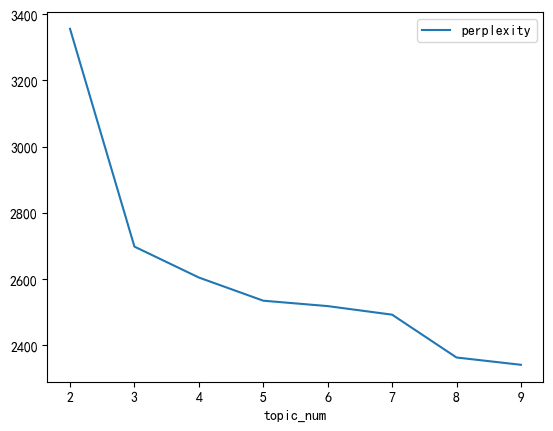

In [34]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

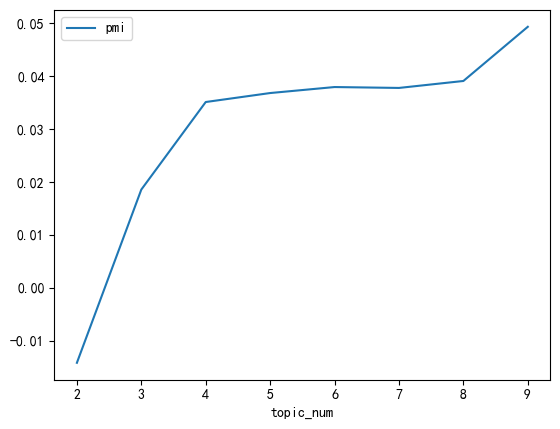

In [35]:
result.plot.line(x='topic_num', y='pmi')

就訓練結果來看，perplexity 在 7 之後都不錯，coherence 最高則是 9

## 5. 視覺化呈現

**5.1 產生 LDAvis 結果**

LDAvis 是我們經常會使用的視覺化工具，目的為幫助我們解釋主題模型中，在我們建構好主題模型得到 θ(文件的主題分佈) 跟 φ(主題的字分佈)，透過 pyLDAvis 將主題降維成二維，以網頁的形式供我們查看。

+ 四個主題數，因此有四個圈圈
+ 圓越大代表 document 越大
+ 右邊可以看到主題的字分佈
+ 右上幫有一個 bar 調整 lambda：當 lambda=1 也就是代表本來的字分佈 φ，將 lambda 縮越小可以看到越唯一的字，好的分佈是 φ 高且唯一，因此我們要在這兩者間取平衡
+ 圓心越相近，代表主題會越相似；反之，圓心分越開代表主題有唯一性<br>
  --> 假設詞彙本來有 100 字，維度應該是 100，假如本來維度接近(相近)的話，降維後也會接近(相近)

以下用主題數 9 來做 LDAvis 的結果範例

In [154]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 9,
    id2word=dictionary,
    random_state = 1500,
    passes = 10 # 訓練次數
    )

2023-05-03 21:14:33,856 : INFO : using symmetric alpha at 0.1111111111111111
2023-05-03 21:14:33,858 : INFO : using symmetric eta at 0.1111111111111111
2023-05-03 21:14:33,861 : INFO : using serial LDA version on this node
2023-05-03 21:14:33,870 : INFO : running online (multi-pass) LDA training, 9 topics, 10 passes over the supplied corpus of 5406 documents, updating model once every 2000 documents, evaluating perplexity every 5406 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-03 21:14:33,872 : INFO : PROGRESS: pass 0, at document #2000/5406
2023-05-03 21:14:34,686 : INFO : merging changes from 2000 documents into a model of 5406 documents
2023-05-03 21:14:34,692 : INFO : topic #7 (0.111): 0.012*"經典賽" + 0.009*"今天" + 0.007*"先發" + 0.007*"比賽" + 0.006*"中華隊" + 0.006*"球員" + 0.006*"安打" + 0.006*"球迷" + 0.005*"球隊" + 0.005*"投手"
2023-05-03 21:14:34,694 : INFO : topic #0 (0.111): 0.029*"經典賽" + 0.014*"棒球" + 0.012*"世界" + 0.010*"中華隊" + 0.010*"日本" + 0.009*"大聯盟" + 0.008*"今天"

In [155]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.140168  0.125790       1        1  21.025925
8     -0.069285 -0.126828       2        1  15.419152
1     -0.203575 -0.054898       3        1  13.600894
5      0.248209  0.043222       4        1  10.606848
2     -0.156401  0.042031       5        1  10.283248
7      0.086633  0.104907       6        1   9.296069
3      0.046730 -0.022113       7        1   8.639842
0      0.083837  0.142639       8        1   5.944477
4      0.104020 -0.254751       9        1   5.183544, topic_info=    Term          Freq         Total Category  logprob  loglift
57   經典賽  10364.000000  10364.000000  Default  30.0000  30.0000
81   中華隊   5858.000000   5858.000000  Default  29.0000  29.0000
115   棒球   4806.000000   4806.000000  Default  28.0000  28.0000
437   安打   3578.000000   3578.000000  Default  27.0000  27.0000
78    世界   4981.000000   4981.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
375   表示    315.969792   4042.336070   Topic9  -5.1896   0.4107
245   記者    214.501303   1880.874604   Topic9  -5.5769   0.7885
116  棒球場    199.502916   1238.397015   Topic9  -5.6494   1.1339
109   時間    188.292000   1977.333090   Topic9  -5.7072   0.6082
251   關注    179.187046    567.343655   Topic9  -5.7568   1.8071

[697 rows x 6 columns], token_table=       Topic      Freq Term
term                       
8421       1  0.253464   一哥
8421       4  0.027777   一哥
8421       5  0.003472   一哥
8421       8  0.711781   一哥
416        2  0.040031   一壘
...      ...       ...  ...
12270      6  0.978130   鶯歌
1164       2  0.023313   鷹隊
1164       3  0.973308   鷹隊
1103       3  0.923487   龍隊
1103       5  0.075477   龍隊

[1862 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 2, 6, 3, 8, 4, 1, 5])

1. NBA
2. 經典賽
3. 中職

In [156]:
pyLDAvis.save_html(p, "lda_zh.html")

## 6. GuidedLDA

- 原始套件: <https://github.com/vi3k6i5/GuidedLDA>  
- 31lab 家銘修改版本: <https://github.com/Text-Analytics-and-Retrieval/GuidedLDA>

安裝方式:  
`pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA`  
經測試，在 `python3.7`, `python3.8` 可正常執行

In [157]:
import guidedlda

In [158]:
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('下放', '二壘打', '交手', '他將', '修斯', '兄弟', '克里夫蘭', '兩年', '共同', '出發')

In [159]:
word2id = dictionary.token2id

In [160]:
seed_topic_list = [
    ["大谷翔平", "經典賽", "大聯盟", "先發", "張育成"],
    ["林昀儒","莊智淵","鄭怡靜","桌球","挑戰賽"],
    ["湖人", "勇士", "太陽", "公鹿","籃網","金塊", "熱火", "尼克"],
    ["林志傑","楊敬敏","勇士","國王","夢想家","鋼鐵人"],
    ["周天成","戴資穎","王子維","王齊麟","李洋","盧敬堯","楊博涵","楊博軒","李哲輝","羽球","公開賽","奧運","亞運"],
    ["海神","台啤","雲豹","太陽","台鋼"]
]

In [161]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [162]:
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

In [163]:
model = guidedlda.GuidedLDA(n_topics=6, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2023-05-03 21:15:11,519 : INFO : n_documents: 5406
2023-05-03 21:15:11,520 : INFO : vocab_size: 14837
2023-05-03 21:15:11,520 : INFO : n_words: 1093534
2023-05-03 21:15:11,520 : INFO : n_topics: 6
2023-05-03 21:15:11,521 : INFO : n_iter: 100
2023-05-03 21:15:14,703 : INFO : <0> log likelihood: -11319500
2023-05-03 21:15:15,484 : INFO : <20> log likelihood: -8977376
2023-05-03 21:15:16,207 : INFO : <40> log likelihood: -8909137
2023-05-03 21:15:16,918 : INFO : <60> log likelihood: -8877218
2023-05-03 21:15:17,643 : INFO : <80> log likelihood: -8859789
2023-05-03 21:15:18,359 : INFO : <99> log likelihood: -8847968


In [164]:
n_top_words = 10
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 經典賽 中華隊 棒球 今天 安打 世界 日本 投手 先發 大谷翔平
Topic 1: 高中 今天 馬拉松 拿下 冠軍 比賽 台灣 聯賽 最後 世界
Topic 2: 比賽 季後賽 球隊 湖人 勇士 今天 球員 籃板 詹姆斯 西區
Topic 3: 今天 林書豪 主場 聯盟 籃板 比賽 領先 雲豹 鋼鐵人 助攻
Topic 4: 選手 賽事 台灣 運動 今天 今年 提供 表示 經典賽 世界
Topic 5: 球員 表示 球隊 今年 悍將 去年 今天 投手 先發 中信


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022530 -0.117106       1        1  25.103330
5      0.074796  0.166318       2        1  22.103338
2     -0.143068  0.137395       3        1  17.817974
4      0.262244  0.043019       4        1  15.537097
1      0.052183 -0.210483       5        1  10.580862
3     -0.223625 -0.019143       6        1   8.857398, topic_info=     Term          Freq         Total Category  logprob  loglift
57    經典賽  10560.000000  10560.000000  Default  30.0000  30.0000
81    中華隊   5872.000000   5872.000000  Default  29.0000  29.0000
437    安打   3703.000000   3703.000000  Default  28.0000  28.0000
647    高中   2356.000000   2356.000000  Default  27.0000  27.0000
115    棒球   4938.000000   4938.000000  Default  26.0000  26.0000
...   ...           ...           ...      ...      ...      ...
53     球隊    543.310474   4933.078000   Topic6  -5.1833   0.2179
7779   國王    401.493068    921.127659   Topic6  -5.4858   1.5935
625    戰績    454.424917   2626.880923   Topic6  -5.3620   0.6694
160    拿下    434.450634   2866.492653   Topic6  -5.4069   0.5372
57    經典賽    427.459635  10560.988577   Topic6  -5.4231  -0.7831

[420 rows x 6 columns], token_table=       Topic      Freq Term
term                       
261        1  0.068505   一軍
261        2  0.932087   一軍
9294       3  0.371659  三分球
9294       6  0.628458  三分球
1888       1  0.999735   三振
...      ...       ...  ...
5283       6  1.001034   魔獸
9830       3  1.000581   鵜鶘
1164       2  1.000377   鷹隊
14045      4  1.000388  黃筱雯
1103       2  1.000582   龍隊

[754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 5, 2, 4])

## 7. 主題分佈的應用，搭配其他文章資訊

In [168]:
# 取得每條新聞的主題分佈
topics_doc = best_model.get_document_topics(corpus)

In [169]:
topics_doc[100]

[(1, 0.22559384), (4, 0.32359293), (5, 0.1824725), (8, 0.2652998)]

In [170]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.03223895, 0.62183702, ..., 0.        , 0.        ,
        0.31510845],
       [0.        , 0.47204643, 0.        , ..., 0.        , 0.        ,
        0.19716321],
       [0.        , 0.        , 0.20455584, ..., 0.        , 0.        ,
        0.63096923],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.84505272,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.97850633,
        0.        ],
       [0.        , 0.01017951, 0.        , ..., 0.03801164, 0.87926084,
        0.        ]])

In [171]:
udn['topic_label'] = m_theta.argmax(axis=1) + 1

In [172]:
udn['topic_label'].value_counts()

topic_label
7    1301
2     975
9     703
3     587
6     508
4     414
8     360
1     336
5     222
Name: count, dtype: int64

In [173]:
udn.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,美國職棒克里夫蘭守護者外野手帕拉修斯將加入荷蘭國家隊參加月日起在台中的經典賽首輪他與台灣好手...,https://udn.com/news/story/10785/6946445,運動,2023-02-03 11:08:00,"[美國, 職棒, 克里夫蘭, 守護, 外野手, 帕拉, 修斯將, 加入, 荷蘭, 國家隊, ...",3
1,中華隊備戰世界棒球經典賽規畫場自辦熱身賽今天公布前場比賽時間皆未售票未開放球迷進場月底則有對...,https://udn.com/news/story/10785/6946844,運動,2023-02-03 12:49:00,"[中華隊, 備戰, 世界, 棒球, 經典賽, 規畫, 自辦, 熱身賽, 今天, 公布, 前場...",2
2,世界棒球經典賽即將在月日開打各國不只擁有眾多大咖球星連教練團也相當豪華日媒昨日也整理本屆賽事...,https://udn.com/news/story/10785/6947136,運動,2023-02-03 14:40:00,"[世界, 棒球, 經典賽, 開打, 各國, 擁有, 眾多, 大咖, 球星, 教練團, 豪華,...",9
3,世界棒球經典賽即將在月開打被視為奪冠熱門的多明尼加隊組隊卻不如預期順利先前提出的人名單中有人...,https://udn.com/news/story/10785/6947368,運動,2023-02-03 15:45:00,"[世界, 棒球, 經典賽, 開打, 視為, 奪冠, 熱門, 多明尼加隊, 組隊, 預期, 順...",3
4,日職西武隊台灣投手張奕今天春訓分組從一軍調往二軍傳出右肩不適所屬經紀公司信心野球也證實有發炎...,https://udn.com/news/story/10785/6947409,運動,2023-02-03 15:49:00,"[日職, 西武隊, 台灣, 投手, 張奕, 今天, 春訓, 分組, 一軍, 調往, 二軍, ...",3


In [174]:
udn['artDate'] = pd.to_datetime(udn['artDate'])

In [175]:
udn['artDate'].dt.date

0       2023-02-03
1       2023-02-03
2       2023-02-03
3       2023-02-03
4       2023-02-03
           ...    
5401    2023-03-13
5402    2023-03-13
5403    2023-03-13
5404    2023-03-13
5405    2023-03-15
Name: artDate, Length: 5406, dtype: object

In [176]:
udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2023-02-01  7              0.370370
            3              0.240741
            4              0.203704
            6              0.074074
            2              0.037037
                             ...   
2023-05-02  3              0.098039
            1              0.078431
            6              0.058824
            8              0.039216
            4              0.019608
Name: proportion, Length: 715, dtype: float64

In [177]:
date_topic = udn.groupby(udn['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5,6,7,8,9
artDate,,,,,,,,,
2023-02-01,0.037037,0.037037,0.240741,0.203704,NaN,0.074074,0.370370,NaN,0.037037
2023-02-02,0.084746,0.033898,0.186441,0.135593,0.016949,0.084746,0.423729,0.016949,0.016949
2023-02-03,0.065217,0.065217,0.217391,0.086957,0.086957,0.065217,0.369565,0.021739,0.021739
2023-02-04,0.142857,0.023810,0.190476,0.166667,0.095238,0.023810,0.357143,NaN,NaN
2023-02-05,0.142857,0.023810,0.071429,0.047619,0.023810,0.047619,0.547619,0.023810,0.071429


<Axes: xlabel='artDate'>

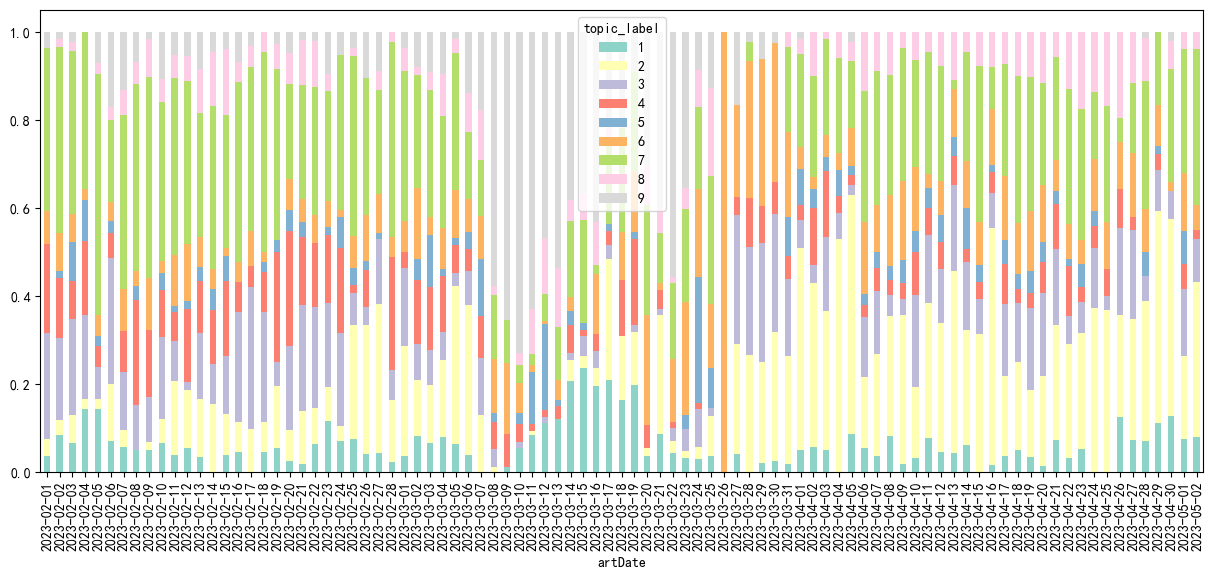

In [178]:
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)

由上圖可知 03/26全部都在討論主題六(跑步相關之議題)